In [2]:
from calibrate import Calibrate

import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import os
%matplotlib inline



In [3]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
output_images = "output_images/"
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

calibrate = Calibrate(images, nx, ny)
print("Calibration Complete")

Calibration Complete


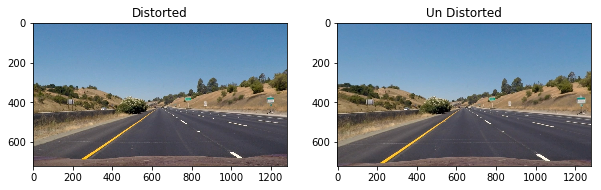

In [33]:
images = glob.glob('./test_images/*.jpg')
undistorted_images = "undistorted_images"
if not os.path.exists(output_images+undistorted_images):
    os.makedirs(output_images+undistorted_images)
undistorted_images += "/"

rows = len(images)

fig = plt.figure(figsize=(10,150))
for i in range(1):
    img = mpimage.imread(images[i])
    undistorted_img = calibrate.undistort(img)
    output_fname = output_images+undistorted_images+images[i].split("\\")[-1]
    cv2.imwrite(output_fname, cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2BGR))
    fig.add_subplot(rows, 2, i*2+1)
    plt.title("Distorted")
    plt.imshow(img)
    fig.add_subplot(rows, 2, i*2+2)
    plt.title("Un Distorted")
    #print(np.max(cv2.cvtColor(img,cv2.COLOR_RGB2HLS)[:,:,0]))
    plt.imshow(undistorted_img)
plt.show()

In [4]:
import thresholdutil as tu
def threshold_pipeline(img):
    mag_binary = tu.mag_thresh(img, mag_thresh=(70, 150))
    dir_binary = tu.dir_threshold(img, sobel_kernel=5, thresh=(0.7, 1.3))
    sx_binary = tu.abs_sobel_thresh(img, sobel_kernel=15, thresh=(10, 200))
    
    # Convert to HLS Colorspace
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sat_img = np.dstack((hls_img[:,:,2],hls_img[:,:,2],hls_img[:,:,2]))
    mag_s_binary = tu.mag_thresh(sat_img, mag_thresh=(70, 150))
    dir_s_binary = tu.dir_threshold(sat_img, sobel_kernel=5, thresh=(0.7, 1.3))
    
    # Convert to HSV Colorspace
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    
    # Detect yellow line
    yellow_hsv_low = (0, 80, 200)
    yellow_hsv_high = (45, 255, 255)
    yellow_line_binary = tu.color_threshold(hsv_img, low=yellow_hsv_low, high=yellow_hsv_high) 
    
    # Detect white line
    white_hls_low = (0, 130, 0)
    white_hls_high = (255, 255, 255)
    white_line_binary = tu.color_threshold(hls_img, low=white_hls_low, high=white_hls_high)
    s_binary = tu.binary_threshold(hls_img[:,:,2], thresh=(160, 255))
    l_binary = tu.binary_threshold(hls_img[:,:,1], thresh=(0, 120))
    h_binary = tu.binary_threshold(hls_img[:,:,0], thresh=(25, 35))
    
    gray_dir_mag = np.zeros_like(dir_binary)
    gray_dir_mag[(dir_binary == 1) & (mag_s_binary == 1)] = 1
    
    sat_dir_mag = np.zeros_like(dir_binary)
    sat_dir_mag[(dir_s_binary == 1) & (mag_binary == 1)] = 1
    
    res_bin = np.zeros_like(dir_binary)    
    res_bin[((gray_dir_mag == 1) | (sat_dir_mag == 1)) | ((yellow_line_binary == 1) | (white_line_binary == 1))] = 1
    #res_bin[] = 1
    #res_bin[] = 1
    #res_bin[(s_binary == 1) | (sx_binary == 1)] = 1
    #res_bin[(s_binary == 1)] = 1
    #res_bin[(h_binary == 1)] = 1
    res = np.copy(res_bin)
    
    res[(res_bin == 0) | (l_binary == 1)] = 0
    
    
    #return (yellow_line_binary,white_line_binary,gray_dir_mag,sat_dir_mag,l_binary,res)
    return res

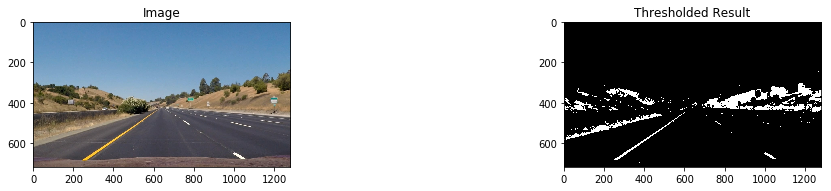

In [7]:

images = glob.glob('./test_images/*.jpg')
thresholded_images = "thresholded_images"
if not os.path.exists(output_images+thresholded_images):
    os.makedirs(output_images+thresholded_images)
thresholded_images += "/"

rows = len(images)

fig = plt.figure(figsize=(65, 25))
for i in range(1):
    img = mpimage.imread(images[i])
    output_fname = output_images+thresholded_images+images[i].split("\\")[-1]
    
    res_bin = threshold_pipeline(img)
    output_img = np.dstack((res_bin, res_bin, res_bin))*255
    cv2.imwrite(output_fname, output_img)
    
    #y,w,g,s,l,r = threshold_pipeline(img)
    # y = np.dstack((y, y, y))*255
    # w = np.dstack((w, w, w))*255
    # g = np.dstack((g, g, g))*255
    # s = np.dstack((s, s, s))*255
    # l = np.dstack((l, l, l))*255
    # r = np.dstack((r, r, r))*255
    
    fig.add_subplot(rows, 7, i*7+1)
    plt.title("Image")
    plt.imshow(img)
    fig.add_subplot(rows, 7, i*7+2)
    plt.title("Thresholded Result")
    plt.imshow(output_img)
    # fig.add_subplot(rows, 7, i*7+3)
    # plt.title("White Line")
    # plt.imshow(w)
    # fig.add_subplot(rows, 7, i*7+4)
    # plt.title("Gryscl Mag & Grad")
    # plt.imshow(g)
    # fig.add_subplot(rows, 7, i*7+5)
    # plt.title("Saturtn Mag & Grad")
    # plt.imshow(s)
    # fig.add_subplot(rows, 7, i*7+6)
    # plt.title("Luminance to remove")
    # plt.imshow(l)
    # fig.add_subplot(rows, 7, i*7+7)
    # plt.title("Result")
    # plt.imshow(r)
plt.show()

In [8]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [9]:
from perspectivetransform import PerspectiveTransform
xy_bl = (230, 693)
xy_tl = (591, 450)
xy_tr = (689, 450)
xy_br = (1076, 693)
src_pts = [xy_bl, xy_tl, xy_tr, xy_br]

xy_bl = (300, 719)
xy_tl = (300, 0)
xy_tr = (980, 0)
xy_br = (980, 719)
dst_pts = [xy_bl, xy_tl, xy_tr, xy_br]
pt = PerspectiveTransform(src_pts, dst_pts)

xy_bl = (150, 720)
xy_tl = (451, 450)
xy_tr = (839, 450)
xy_br = (1130, 720)
roi_pts = np.array([[xy_bl, xy_tl, xy_tr, xy_br]])


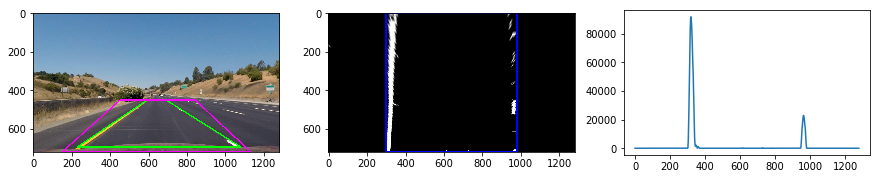

In [12]:

#images = ['./test_images/straight_lines1.jpg']
images = glob.glob('./test_images/*.jpg')
perspective_images = "perspective_images"
if not os.path.exists(output_images+perspective_images):
    os.makedirs(output_images+perspective_images)
perspective_images += "/"

rows = len(images)

fig = plt.figure(figsize=(15, 25))
for i in range(1):
    img = mpimage.imread(images[i])
    output_fname = output_images+perspective_images+images[i].split("\\")[-1]
    output_undist_fname = output_images+perspective_images+"undist_"+images[i].split("\\")[-1]
    
    undistorted_img = calibrate.undistort(img)
    thresh_img = threshold_pipeline(undistorted_img)
    thresh_img = np.dstack((thresh_img, thresh_img, thresh_img))*255
    roi_img = region_of_interest(thresh_img,roi_pts) 
    output_undistorted_img = pt.transform(undistorted_img)
    
    output_img = pt.transform(roi_img)
    
    output_img_gray = output_img[:, :, 0]
    histogram = np.sum(output_img_gray[(output_img_gray.shape[0]//2):,:],axis=0)
    
    cv2.imwrite(output_undist_fname, cv2.cvtColor(output_undistorted_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_fname, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))
    
    cv2.polylines(undistorted_img,np.array([src_pts]),True,(0,255,0),thickness=5)
    cv2.polylines(output_img,np.array([dst_pts]),True,(0,0,255),thickness=10)
    cv2.polylines(undistorted_img,roi_pts,True,(255,0,255),thickness=5)
    
    fig.add_subplot(rows, 3, i*3+1)
    plt.imshow(undistorted_img)
    fig.add_subplot(rows, 3, i*3+2)
    plt.imshow(output_img) 
    fig.add_subplot(rows, 3, i*3+3)
    plt.plot(histogram)
    
    

plt.show()

15873.1459981597 4174.2473878903


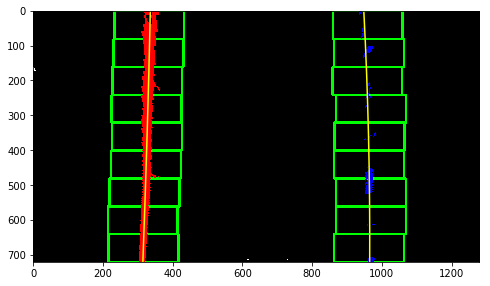

In [79]:
from curveutil import find_base_curve
from curve import Curve

#images = ['./test_images/straight_lines1.jpg']
images = glob.glob('./test_images/*.jpg')
curve_images = "curve_images"
if not os.path.exists(output_images+curve_images):
    os.makedirs(output_images+curve_images)
curve_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))

left_curve = Curve()
right_curve = Curve()
for i in range(1):
    img = mpimage.imread(images[i])
    output_fname = output_images+curve_images+images[i].split("\\")[-1]
    
    undistorted_img = calibrate.undistort(img)
    thresh_img = threshold_pipeline(undistorted_img)
    #thresh_img = np.dstack((thresh_img, thresh_img, thresh_img))*255
    roi_img = region_of_interest(thresh_img,roi_pts) 
    output_undistorted_img = pt.transform(undistorted_img)
    
    perspective_img = pt.transform(roi_img)
    
    output_img = find_base_curve(perspective_img, left_curve, right_curve)
    
    print(left_curve.radius_of_curvature, right_curve.radius_of_curvature)
    #cv2.imwrite(output_undist_fname, cv2.cvtColor(output_undistorted_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_fname, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))
    # 
    # cv2.polylines(undistorted_img,np.array([src_pts]),True,(0,255,0),thickness=5)
    # cv2.polylines(output_img,np.array([dst_pts]),True,(0,0,255),thickness=10)
    # cv2.polylines(undistorted_img,roi_pts,True,(255,0,255),thickness=5)
    
    # fig.add_subplot(rows, 3, i*3+1)
    # plt.imshow(undistorted_img)
    # fig.add_subplot(rows, 3, i*3+2)
    # plt.imshow(output_img) 
    # fig.add_subplot(rows, 3, i*3+3)
    # plt.plot(histogram)
    ploty = np.linspace(0, output_img.shape[0]-1, output_img.shape[0] )
    left_fitx = left_curve.current_fit[0]*ploty**2 + left_curve.current_fit[1]*ploty + left_curve.current_fit[2]
    right_fitx = right_curve.current_fit[0]*ploty**2 + right_curve.current_fit[1]*ploty + right_curve.current_fit[2]

    plt.imshow(output_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    

    plt.show()

In [75]:
from curveutil import find_base_curve
def process_image(img):
    undistorted_img = calibrate.undistort(img)
    thresh_img = threshold_pipeline(undistorted_img)
    #thresh_img = np.dstack((thresh_img, thresh_img, thresh_img))*255
    roi_img = region_of_interest(thresh_img,roi_pts) 
    #output_undistorted_img = pt.transform(undistorted_img)
    
    perspective_img = pt.transform(roi_img)
    
    output_img = find_base_curve(perspective_img, left_curve, right_curve)
    
    warp_zero = np.zeros_like(perspective_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, output_img.shape[0]-1, output_img.shape[0])
    left_fitx = left_curve.get_fit(ploty)
    right_fitx = right_curve.get_fit(ploty)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = pt.inverse_transform(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    font = cv2.FONT_HERSHEY_COMPLEX
    
    xm_per_pix = 3.7/700
    img_mid = img.shape[1] / 2
     
    
    a = left_curve.current_fit[0]
    b = left_curve.current_fit[1]
    c = left_curve.current_fit[2]
    y = 720
    left_line_base = (a*y**2)+(b*y)+c
    
    a = right_curve.current_fit[0]
    b = right_curve.current_fit[1]
    c = right_curve.current_fit[2]
    y = 720
    right_line_base = (a*y**2)+(b*y)+c
    lane_centre = (left_line_base+right_line_base)/2
    dist_center = (lane_centre - img_mid) * xm_per_pix
    
    pos = "left" if dist_center >= 0 else "right"
    pos_text = "{} m {} of center".format(abs(round(dist_center,2)),pos)

    cv2.putText(result, pos_text, (10,50), font, 1,(255,255,255),2)
    avg_rad = round(np.mean([left_curve.radius_of_curvature, right_curve.radius_of_curvature]),0)
    roc_text = "Radius of Curvature: {}(m)".format(avg_rad)
    cv2.putText(result, roc_text, (10,100), font, 1,(255,255,255),2)
    #res =np.dstack((perspective_img,pt.inverse_transform(perspective_img),perspective_img))*255
    #result = cv2.addWeighted(undistorted_img, 1, res, 2, 0)
    return result
    

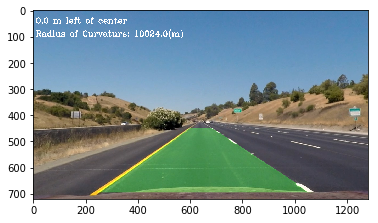

In [80]:
from curve import Curve

#images = ['./test_images/straight_lines1.jpg']
images = glob.glob('./test_images/*.jpg')
final_output = "final_output"
if not os.path.exists(output_images+final_output):
    os.makedirs(output_images+final_output)
final_output += "/"

rows = len(images)


left_curve = Curve()
right_curve = Curve()
for i in range(1):
    img = mpimage.imread(images[i])
    output_fname = output_images+final_output+images[i].split("\\")[-1]
    
    output_img = process_image(img)
    
    #print(left_curve.radius_of_curvature, right_curve.radius_of_curvature)
    cv2.imwrite(output_fname, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))

    plt.imshow(output_img)
    plt.show()

In [78]:
from moviepy.editor import VideoFileClip

vid_output = 'res_vid.mp4'
vid_in = VideoFileClip("project_video.mp4")#.subclip('00:00:38.00', '00:00:42.00')

# NOTE: this function expects color images

left_curve = Curve()
right_curve = Curve()
count = 1
def save_frames(img): 
    cv2.imwrite("./output_images/test/test"+str(count)+".jpg", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    out = process_image(img)
    cv2.imwrite("./output_images/test/out"+str(count)+".jpg", cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
    global count
    count= count+1
    return out

vid_out = vid_in.fl_image(process_image) 
vid_out.write_videofile(vid_output, audio=False)

vid_in.reader.close()
vid_in.audio.reader.close_proc()
vid_out.reader.close()
vid_out.audio.reader.close_proc()

[MoviePy] >>>> Building video res_vid.mp4
[MoviePy] Writing video res_vid.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:59<00:00,  2.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: res_vid.mp4 



In [44]:
from moviepy.editor import VideoFileClip

vid_output = 'res_challenge_vid.mp4'

vid_in = VideoFileClip("challenge_video.mp4")

# NOTE: this function expects color images

left_curve = Curve()
right_curve = Curve()


vid_out = vid_in.fl_image(process_image) 
vid_out.write_videofile(vid_output, audio=False)

vid_in.reader.close()
vid_in.audio.reader.close_proc()
vid_out.reader.close()
vid_out.audio.reader.close_proc()

[MoviePy] >>>> Building video res_challenge_vid.mp4
[MoviePy] Writing video res_challenge_vid.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [04:01<00:00,  2.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: res_challenge_vid.mp4 

